In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# conda install pmdarima
import pmdarima as pm

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/ghana_gdp.csv', parse_dates=["year"], index_col = ["year"])
data.rename(columns = {'GDP (current US$)':'VVP'}, inplace = True )
data.head(15)

,VVP
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
1965-01-01,2.053221e+09
1966-01-01,2.126050e+09
1967-01-01,1.746806e+09
1968-01-01,1.666910e+09


<AxesSubplot:xlabel='year'>

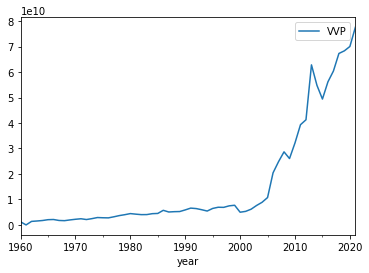

In [3]:
%matplotlib inline 
data.plot()

In [4]:
# Откладываем последние три года из датасета как тестовую выборку для оценки результатов предсказания
train_df = data.loc[:"2017-12-31"]
test_df = data.loc["2018-01-01":]
train_df.shape, test_df.shape

((58, 1), (4, 1))

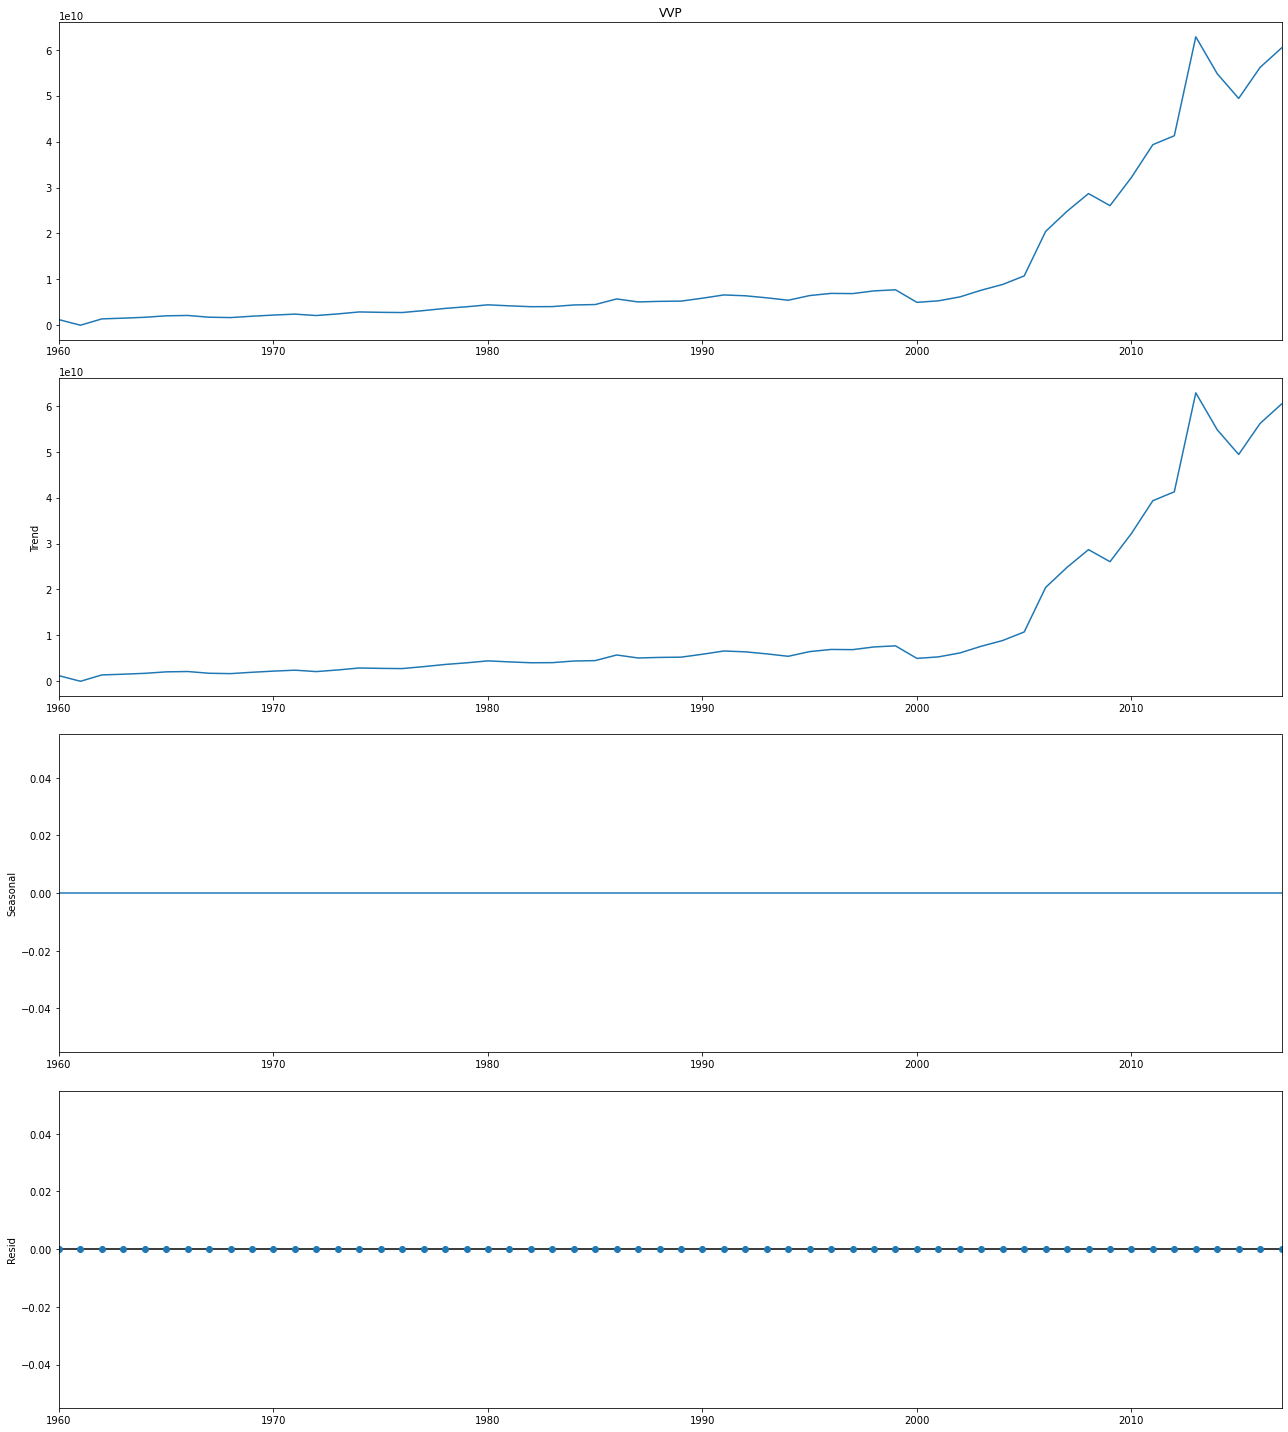

In [5]:
plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df.VVP, model='additive')
result.plot()
plt.show()

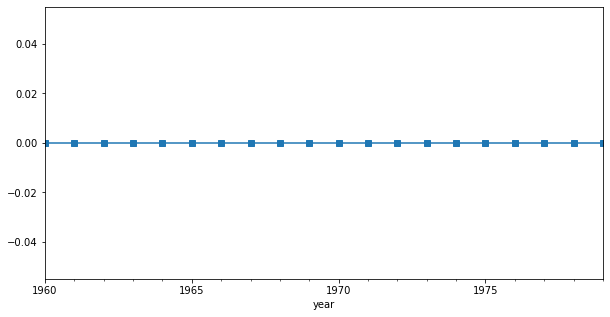

In [6]:
plt.rcParams["figure.figsize"] = 10, 5
result.seasonal[:20].plot(marker = "s")
plt.show()

В целом наблюдается тренд увеличения ВВП. Сезонность не наблюдается. Шума нет.
С 2000 года наблюдается увеличение скорости роста ВВП.

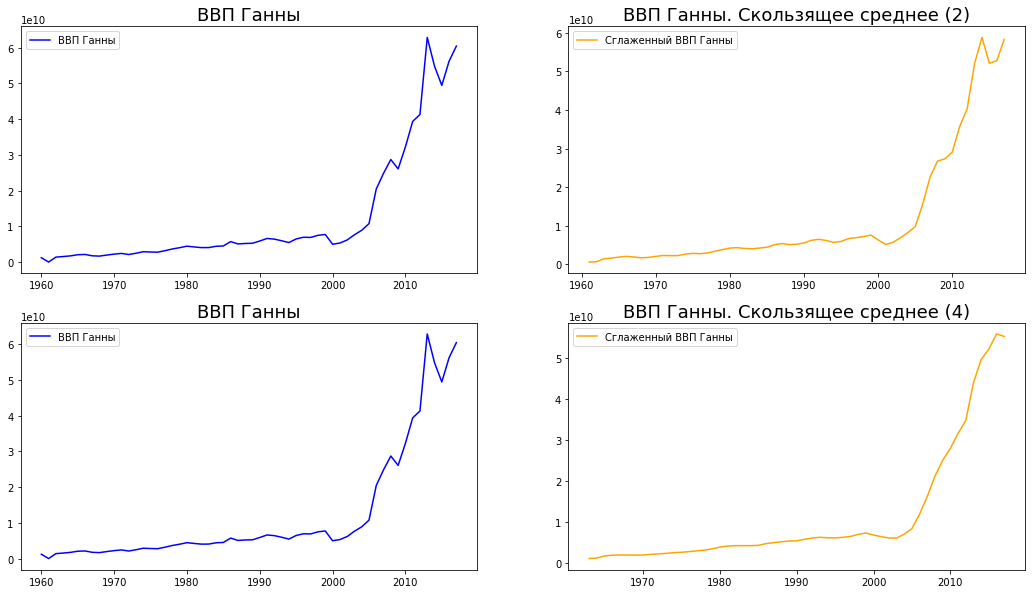

In [7]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(nrows=2, ncols=2)

# Окно в месяц (Window = 2) 
ax[0, 0].plot(train_df.VVP, color = "blue", label = "ВВП Ганны")
ax[0, 0].set_title("ВВП Ганны", size = 18)
ax[0, 0].legend()

ax[0, 1].plot(train_df.VVP.rolling(window=2).mean(), color = "orange", label = "Сглаженный ВВП Ганны")
ax[0, 1].set_title("ВВП Ганны. Скользящее среднее (2)", size = 18)
ax[0, 1].legend()

# Окно в месяц (Window = 20) 
ax[1, 0].plot(train_df.VVP, color = "blue", label = "ВВП Ганны")
ax[1, 0].set_title("ВВП Ганны", size = 18)
ax[1, 0].legend()

ax[1, 1].plot(train_df.VVP.rolling(window=4).mean(), color = "orange", label = "Сглаженный ВВП Ганны")
ax[1, 1].set_title("ВВП Ганны. Скользящее среднее (4)", size = 18)
ax[1, 1].legend()

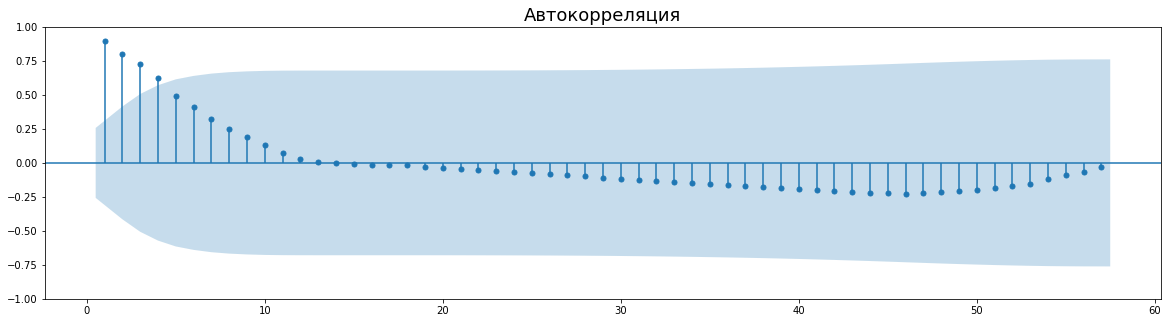

In [8]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df.VVP, zero = False, lags = 57)
plt.title('Автокорреляция', size = 18)
plt.show()

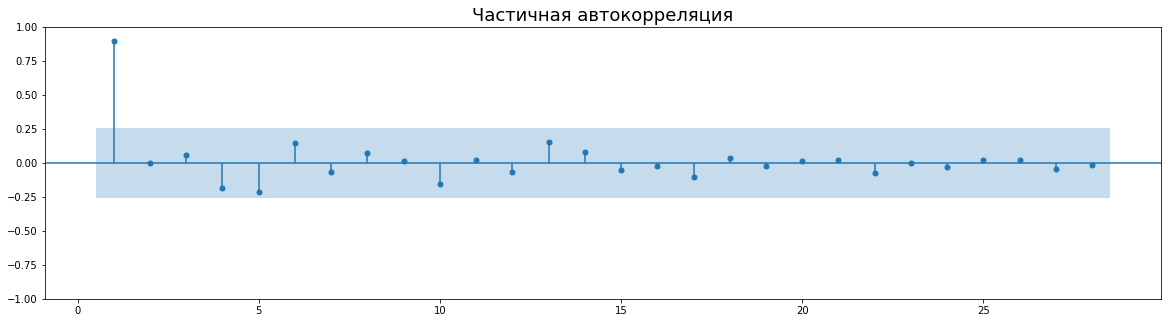

In [9]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df.VVP, zero = False, lags = 28, method='ywm')
plt.title('Частичная автокорреляция', size = 18)
plt.show()

In [10]:
# Оценка стационарности временного ряда с помощью теста Дики-Фуллера 
adfuller(train_df["VVP"])

(0.539330624834918,
 0.9860207453998459,
 8,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 2146.523587302631)

In [11]:
test1 = adfuller(train_df["VVP"])
print ('adf: ', test1[0])
print ('p-value: ', test1[1])
print ('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']: 
    print ('Ряд нестационарен')
else:
    print ('Ряд стационарен')

adf:  0.539330624834918
p-value:  0.9860207453998459
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
Ряд нестационарен


Полученное значение статистики больше пороговой (любого порога). Следовательно принимается гипотеза о нестационарности ряда.

In [12]:
# Функция для построения графика автокорреляции
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)
    
    sgt.plot_acf(series, lags = 2, ax = axes[0])
    sgt.plot_pacf(series, lags = 2, ax = axes[1])
    plt.show()

## Дифференцирование ряда

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


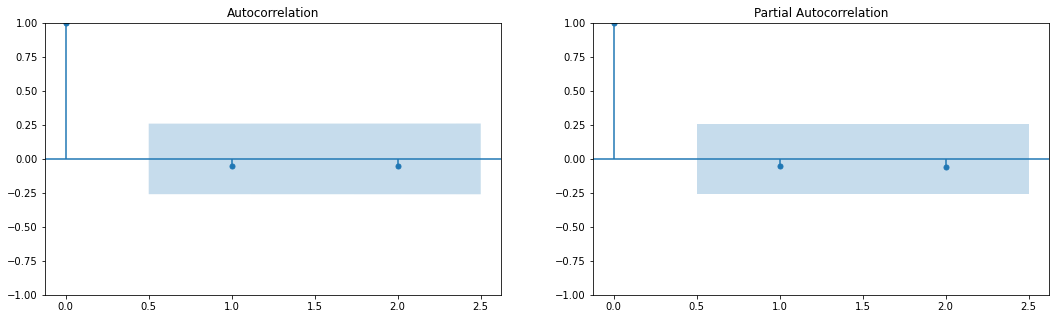

(-0.7957779955549775,
 0.820359104630642,
 7,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 2099.4000415393116)

In [13]:
plot_acf_pacf(train_df["VVP"].diff(1).dropna())
adfuller(train_df["VVP"].diff(1).dropna())

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


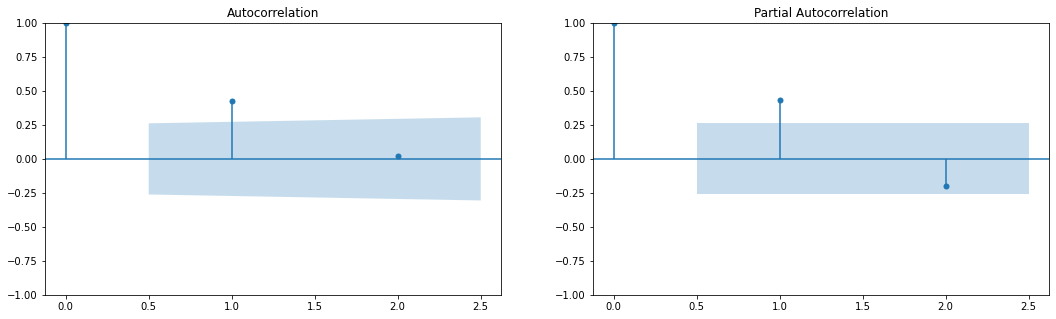

(-2.4258384354902622,
 0.13457609615935312,
 11,
 44,
 {'1%': -3.5885733964124715,
  '5%': -2.929885661157025,
  '10%': -2.6031845661157025},
 2055.6331533657785)

In [14]:
plot_acf_pacf(train_df["VVP"].diff(2).dropna())
adfuller(train_df["VVP"].diff(2).dropna())

Вторая производная позволила получить стационарность ряда, для уровня значимости 0.05. Принимаем параметр p=2, d=2.

## ARIMA, SARIMA

Начнем построение модели ARIMA со следующими параметрами:

* p = 2
* d = 2
* q = 1

Если рассматривать сезонную модель (SARMA), то в модель можно добавить следующие параметры.

* m = 5 (будучи рыночным индексом, данные, скорее всего, будут иметь еженедельно повторяющиеся паттерны, как видно из визуализации)
* P = 2
* D = 2
* Q = 1

In [15]:
# ARIMA
arima_model = ARIMA(train_df["VVP"].dropna(), order = (2, 2, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    VVP   No. Observations:                   58
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -1313.648
Date:                Wed, 01 Mar 2023   AIC                           2635.295
Time:                        00:08:04   BIC                           2643.397
Sample:                    01-01-1960   HQIC                          2638.436
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2737      0.208     -1.316      0.188      -0.681       0.134
ar.L2         -0.2522      0.264     -0.954      0.340      -0.770       0.266
ma.L1         -0.8144      0.115     -7.052      0.000      -1.041      -0.588
sigma2      1.717e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               377.75
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):             252.61   Skew:                             1.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.04e+55. Standard errors may be unstable.
"""

In [16]:
# SARIMAX
model = SARIMAX(train_df["VVP"].dropna(), order = (2, 2, 1))
model_fit = model.fit()
model_fit.summary()

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    VVP   No. Observations:                   58
Model:               SARIMAX(2, 2, 1)   Log Likelihood               -1313.648
Date:                Wed, 01 Mar 2023   AIC                           2635.295
Time:                        00:08:04   BIC                           2643.397
Sample:                    01-01-1960   HQIC                          2638.436
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2737      0.208     -1.316      0.188      -0.681       0.134
ar.L2         -0.2522      0.264     -0.954      0.340      -0.770       0.266
ma.L1         -0.8144      0.115     -7.052      0.000      -1.041      -0.588
sigma2      1.717e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               377.75
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):             252.61   Skew:                             1.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.04e+55. Standard errors may be unstable.
"""

In [17]:
seas_model = SARIMAX(train_df["VVP"].dropna(), order = (2, 2, 1), seasonal_order = (2, 2, 1, 5))
seas_model_fit = seas_model.fit()
seas_model_fit.summary()

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               VVP   No. Observations:                   58
Model:             SARIMAX(2, 2, 1)x(2, 2, 1, 5)   Log Likelihood               -1078.369
Date:                           Wed, 01 Mar 2023   AIC                           2170.738
Time:                                   00:08:05   BIC                           2183.539
Sample:                               01-01-1960   HQIC                          2175.533
                                    - 01-01-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1435      0.410     -0.350      0.727      -0.948       0.661
ar.L2         -0.3051      0.351     -0.868      0.385      -0.994       0.384
ma.L1         -0.9097      0.251     -3.620      0.000      -1.402      -0.417
ar.S.L5       -0.6987      0.834     -0.838      0.402      -2.333       0.935
ar.S.L10      -1.0000      0.942     -1.062      0.288      -2.845       0.845
ma.S.L5       -0.1946      1.067     -0.182      0.855      -2.286       1.897
sigma2       1.93e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                85.59
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):              40.07   Skew:                             1.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.01e+53. Standard errors may be unstable.
"""

In [18]:
smodel = pm.auto_arima(train_df, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=5,
                         start_P=0, seasonal=True,
                         d=1, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=2438.900, Time=0.05 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=2439.034, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=2442.411, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=2442.258, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[5]             : AIC=2436.962, Time=0.04 sec
 ARIMA(1,1,1)(1,1,0)[5]             : AIC=2438.925, Time=0.07 sec
 ARIMA(1,1,1)(1,1,1)[5]             : AIC=2440.879, Time=0.14 sec
 ARIMA(0,1,1)(0,1,0)[5]             : AIC=2440.743, Time=0.02 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=2440.678, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[5]             : AIC=2434.762, Time=0.05 sec
 ARIMA(2,1,1)(1,1,0)[5]             : AIC=2436.560, Time=0.07 sec
 ARIMA(2,1,1)(0,1,1)[5]             : AIC=2436.089, Time=0.08 sec
 ARIMA(2,1,1)(1,1,1)[5]             : AIC=2437.706, Time=0.11 sec
 ARIMA(2,1,0)(0,1,0)[5]             : AIC=2437.060, Time=0.02 sec
 ARIMA(3,1,1)(0,1,0)[5]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   58
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 5)   Log Likelihood               -1213.381
Date:                            Wed, 01 Mar 2023   AIC                           2434.762
Time:                                    00:08:06   BIC                           2442.567
Sample:                                         0   HQIC                          2437.754
                                             - 58                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7640      0.112     -6.800      0.000      -0.984      -0.544
ar.L2         -0.2811      0.109     -2.585      0.010      -0.494      -0.068
ma.L1          0.8983      0.084     10.708      0.000       0.734       1.063
sigma2      1.228e+19   1.64e-21    7.5e+39      0.000    1.23e+19    1.23e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                45.70
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):              23.09   Skew:                             1.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.21e+55. Standard errors may be unstable.
"""

In [19]:
seas_model_b = SARIMAX(train_df["VVP"].dropna(), order = (2, 1, 1), seasonal_order = (0, 1, 0, 5))
seas_model_fit_b = seas_model_b.fit()
seas_model_fit_b.summary()

pred_df = pd.DataFrame(index = data.index)
pred_df["model_preds"] = seas_model_fit_b.predict(start = test_df.index[1], end = test_df.index[-1])


pred_df["VVP"] = data["VVP"]

forecast = seas_model_fit_b.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha = 0.05) # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower VVP"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper VVP"]

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


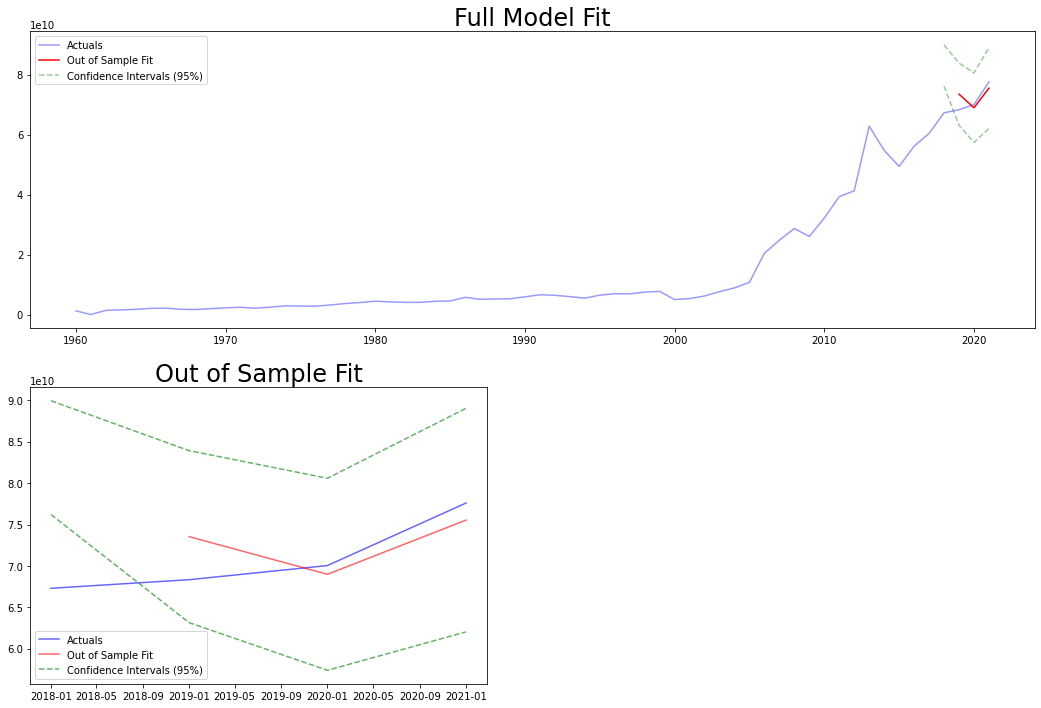

In [20]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["VVP"], color = "blue", label = "Actuals", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit")
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.4)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.4)
plt.title("Full Model Fit", size = 24)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(pred_df.loc[test_df.index]["VVP"], color = "blue", label = "Actuals", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds"], color = "red", linestyle = "-", label = "Out of Sample Fit", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_lower"], color = "green", linestyle = "--", label = "Confidence Intervals (95%)", alpha = 0.6)
plt.plot(pred_df.loc[test_df.index]["model_preds_upper"], color = "green", linestyle = "--", alpha = 0.6)
plt.title("Out of Sample Fit", size = 24)
plt.legend()

plt.show()

Подобранные параметры модели с помощью Auto-arima: seas_model_b = SARIMAX(train_df["VVP"].dropna(), order = (2, 1, 1), seasonal_order = (0, 1, 0, 5)). Дают хорошие предсказания на тестовых данных. 

## Downsampling / Upsampling / Интерполяция

In [21]:
data.isna().sum()

VVP    0
dtype: int64

In [22]:
data['VVP'] = data['VVP'].apply(lambda x: np.nan if x==0 else x)
data.isna().sum()

VVP    1
dtype: int64

In [23]:
data.asfreq('AS').isna().sum()

VVP    1
dtype: int64

Один пропуск.

In [24]:
interpol_data = pd.DataFrame(data['VVP'].interpolate(method='linear'))

In [25]:
interpol_data.asfreq('AS').isna().sum()

VVP    0
dtype: int64

In [26]:
interpol_data.head()

,VVP
year,
1960-01-01,1.217087e+09
1961-01-01,1.299720e+09
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [27]:
# Откладываем последние три года из датасета как тестовую выборку для оценки результатов предсказания
interpol_train_df = interpol_data.loc[:"2017-12-31"]
interpol_test_df = interpol_data.loc["2018-01-01":]
interpol_train_df.shape, interpol_test_df.shape

((58, 1), (4, 1))

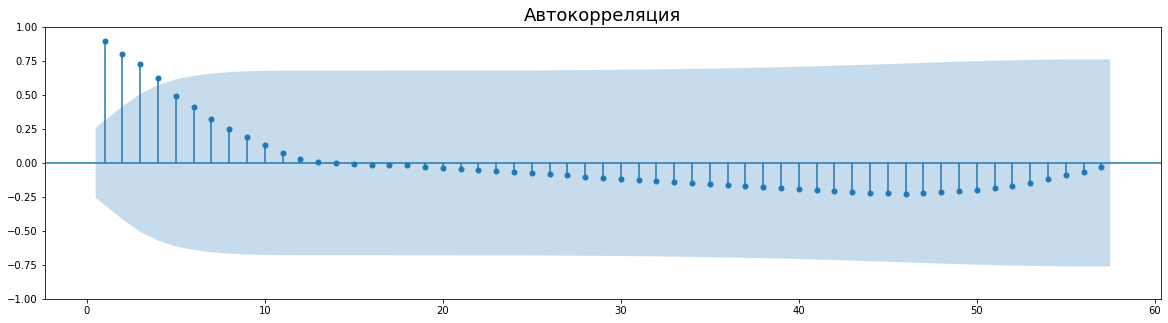

In [28]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(interpol_train_df.VVP, zero = False, lags = 57)
plt.title('Автокорреляция', size = 18)
plt.show()

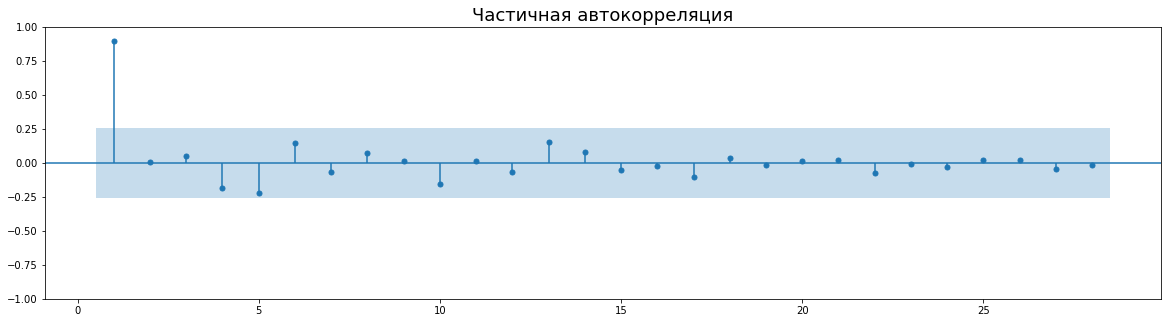

In [29]:
plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(interpol_train_df.VVP, zero = False, lags = 28, method='ywm')
plt.title('Частичная автокорреляция', size = 18)
plt.show()

In [30]:
# Оценка стационарности временного ряда с помощью теста Дики-Фуллера 
adfuller(interpol_train_df["VVP"])

(0.49636386509276065,
 0.9847621588942816,
 8,
 49,
 {'1%': -3.5714715250448363,
  '5%': -2.922629480573571,
  '10%': -2.5993358475635153},
 2146.523587302631)

Изменилось одно значение в начале ряда. Ожидать каких либо изменений не стоит.

In [31]:
smodel = pm.auto_arima(interpol_train_df, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=5,
                         start_P=0, seasonal=True,
                         d=1, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=2437.008, Time=0.07 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=2438.686, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=2442.138, Time=0.02 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=2442.054, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[5]             : AIC=2435.011, Time=0.05 sec
 ARIMA(1,1,1)(1,1,0)[5]             : AIC=2437.009, Time=0.07 sec
 ARIMA(1,1,1)(1,1,1)[5]             : AIC=2438.816, Time=0.11 sec
 ARIMA(0,1,1)(0,1,0)[5]             : AIC=2440.449, Time=0.01 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=2440.344, Time=0.01 sec
 ARIMA(2,1,1)(0,1,0)[5]             : AIC=2432.451, Time=0.05 sec
 ARIMA(2,1,1)(1,1,0)[5]             : AIC=2433.989, Time=0.07 sec
 ARIMA(2,1,1)(0,1,1)[5]             : AIC=2433.416, Time=0.06 sec
 ARIMA(2,1,1)(1,1,1)[5]             : AIC=2435.139, Time=0.08 sec
 ARIMA(2,1,0)(0,1,0)[5]             : AIC=2436.616, Time=0.04 sec
 ARIMA(3,1,1)(0,1,0)[5]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   58
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 5)   Log Likelihood               -1212.226
Date:                            Wed, 01 Mar 2023   AIC                           2432.451
Time:                                    00:08:08   BIC                           2440.256
Sample:                                         0   HQIC                          2435.443
                                             - 58                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7522      0.108     -6.963      0.000      -0.964      -0.540
ar.L2         -0.2875      0.112     -2.570      0.010      -0.507      -0.068
ma.L1          0.9378      0.056     16.764      0.000       0.828       1.047
sigma2      1.228e+19   1.43e-21   8.56e+39      0.000    1.23e+19    1.23e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                34.10
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):             200.99   Skew:                             1.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.9e+55. Standard errors may be unstable.
"""

Действительно наилучшие параметры модели не поменялись.

In [33]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3, test_size = 3)

In [34]:
train_test_groups = tscv.split(interpol_data.VVP) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))

TRAIN size: 53 TEST size: 3
TRAIN size: 56 TEST size: 3
TRAIN size: 59 TEST size: 3
